In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [6]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [7]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.85

In [8]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [9]:
truth = pd.read_hdf(truth.result(), 'data')

In [10]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']

In [11]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [12]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [13]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [ ]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir)
print('assembled data in {:.1f}s'.format((time.time() - start)))

fit models in 283.4s


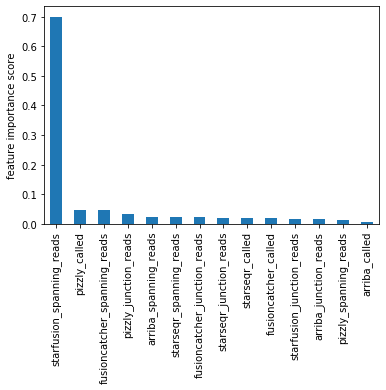

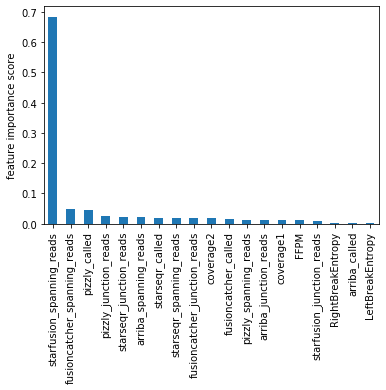

In [42]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = []
for c in callers:
    base_columns += [c + '_called', c + '_spanning_reads', c + '_junction_reads']
base_columns.remove('starfusion_called')
classifiers = []
for features in [
            base_columns,
            base_columns + [
                #'arriba_confidence_low', 'arriba_confidence_medium', 'arriba_confidence_high', 
                #'arriba_reading_frame_in-frame', 'arriba_reading_frame_out-of-frame',
                # 'starfusion_large_anchor_support_YES_LDAS', 'starfusion_large_anchor_support_NO_LDAS',
                'FFPM', 'LeftBreakEntropy', 'RightBreakEntropy',
                'coverage1', 'coverage2'
            ],
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    #label = 'RFC{}F'.format(len(features))
    #trans = 'noop'
    #classifier = ensemble.RandomForestClassifier()
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    plt.figure()
    feature_importances = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
    feature_importances.plot(kind='bar')
    plt.ylabel('feature importance score')

    #label = 'DefaultGBC{}F'.format(len(features))
    #trans = 'noop'
    #classifier = ensemble.GradientBoostingClassifier()
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    

print('fit models in {:.1f}s'.format((time.time() - start)))

In [43]:
x_train.shape, sum(y_train)

((63025, 27), 34000)

In [44]:
start = time.time()
model_data = pd.read_hdf(
    apps.predict(testing_samples, out_dir, classifiers, callers), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 35.7s


In [14]:
summary = apps.make_summary(out_dir, testing_samples)

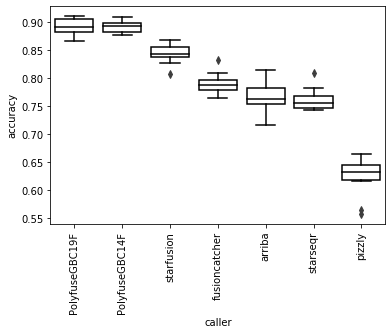

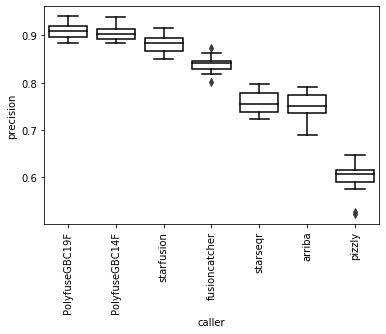

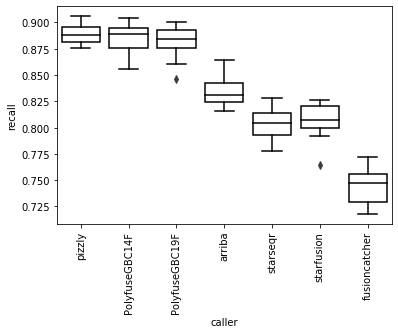

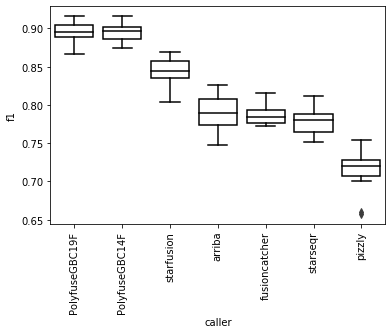

In [15]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [16]:
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
PolyfuseGBC19F,440.250,43.667,59.750,409.417,0.881,0.910,0.892,0.895,0.783
PolyfuseGBC14F,442.250,46.500,57.750,406.583,0.884,0.905,0.891,0.895,0.781
starfusion,403.083,53.167,96.917,399.917,0.806,0.884,0.842,0.843,0.688
fusioncatcher,371.500,71.750,128.500,381.333,0.743,0.838,0.789,0.788,0.584
arriba,417.500,141.500,82.500,311.583,0.835,0.748,0.765,0.789,0.529
starseqr,401.583,129.417,98.417,323.667,0.803,0.757,0.761,0.779,0.519
pizzly,444.833,304.000,55.167,149.083,0.890,0.596,0.625,0.713,0.268


PolyfuseRFC10F
PolyfuseGBC10F
PolyfuseDefaultGBC10F
PolyfuseRFC15F
PolyfuseGBC15F
PolyfuseDefaultGBC15F


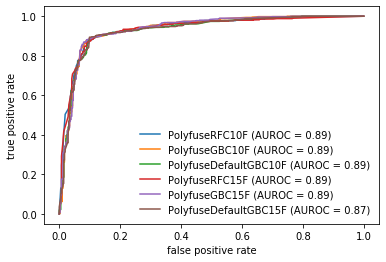

In [77]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

PolyfuseRFC4F
PolyfuseGBC4F
PolyfuseDefaultGBC4F
PolyfuseRFC7F
PolyfuseGBC7F
PolyfuseDefaultGBC7F


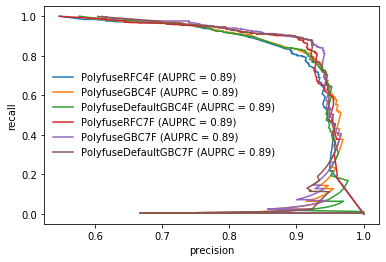

In [27]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [39]:
data = pd.read_pickle('/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04674wt/arriba/fusions.pkl')

In [40]:
data

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,fusion,junction_reads,spanning_reads,caller,sample
0,SRCAP,FAM228A,+/+,+/+,16:30720331,2:24179111,splice-site,splice-site,translocation,downstream,upstream,301,294,300,1624,2064,high,.,.,"duplicates(37),low_entropy(34),mismatches(2)",CGCTGCAGGCTCTCCAAGCGTCAACGCTGTCTCTATGATGACTTCATGGC...ACACTAGCCACAGGCCATTTCATGAGCGTCATCAACATTTTGATGCAGCTGAGAAAAGTTTGCAATCATCCAAATCTGTTCGACCCTCGACCGGTTACCTCCCCTTTCATCACCCCAGGCATCTGCTTCAGCACCGCCTCTCTGGTGCTAAGGGCCACGGATGTCCATCCCCTCCAG___CGGATAGACATGGGTCGATTTGACCTTATTGGCCTGGAAGGTCGTGTCTCTCGATATGAGGCAGACACATTTCTGCCCCGGCACCGCCTCTCTCGCCGGGTACTGTTAGAAGTGGCTACTGCTCCTGACCCCCCACCCCGGCCCAAGCCAGTCAAGATGAAGGTCAACAG|AGATTGGATATGTATTTTCAGCATGTGGATACTTTTAAGGAAAGAAGAAAAGAGATGTTACATAAAAAATGGGTTGAAAATGTTGCAGAGCCTCTTCAGCAGAGAATTATGGAAAAAGTAATTTCATATAAAGAGCTTAAAATGAAACGAGAATGTTGAATATTATTTACAGCACAGACATAAAATG___GTTACAGTCCCACCATTTGTTGATCCTCTGTTTCAAAGACAGCAAGAGGTGGATGAAGAGAGGAGAACTGGTCTTCAGTGTGAGACAG___GAAAACGACATTCCATAAAAGAACTTGAAGAAATAGAGAAGGCCAGGCTGCATGCCAGCTCGCCCTACTTCACTTTCACTTCACACTGTGTGATTCCAAAAGAGTGGCATAAAGCCTCTGCAAGAGCCAGGAGTAAAA,out-of-frame,TLATGHFMSVINILMQLRKVCNHPNLFDPRPVTSPFITPGICFSTASLVLRATDVHPLQRIDMGRFDLIGLEGRVSRYEADTFLPRHRLSRRVLLEVATAPDPPPRPKPVKMKVNr|dwicifsmwillrkeekrcyiknglkmlqslfsrelwkk*,.,FAM228A--SRCAP,595,300,arriba,LIB-04674wt
1,CCL7,VPS29,+/+,-/-,17:34271263,12:110496203,splice-site,splice-site,translocation,downstream,downstream,294,300,300,1303,1270,high,.,.,"duplicates(31),low_entropy(29),mismatches(8)",GAGGGGCTGAGACCAAACCAGAAACCTCCAATTCTCATGTGGAAGCCCATGCCCTCACCCTCCAACATGAAAGCCTCTGCAGCACTTCTGTGTCTGCTGCTCACAGCAGCTGCTTTCAGCCCCCAGGGGCTTGCTCAGCCAG___AAAGACCCAGGACACACCCTCAATGGACTTTTCTTCTTGTTGTTTCATTGCAGTTGGGATTAATACTTCAACTACCTGCTGCTACAGATTTATCAATAAGAAAATCCCTAAGCAGAGGCTGGAGAGCTACAGAAGGACCACCAGTAGCCACTGTCCCCGGGAAGCTGTAAT|TTGGTGTTGGTATTAGGAGATCTGCACATCCCACACCGGTGCAACAGTTTGCCAGCTAAATTCAAAAAACTCCTGGTGCCAGGAAAAATTCAGCACATTCTCTGCACAGGAAACCTTTGCACCAAAGAGAGTTATGACTATCTCAAGACTCTGGCTGGTGATGTTCATATTGTGAGAGGAGACTTCGATGAG___AATCTGAATTATCCAGAACAGAAAGTTGTGACTGTTGGACAGTTCAAAATTGGTCTGATCCATGGACATCAAGTTATTCCATGGGGAGATATGGCCAGCTTAGCCCTGTTGCAGAGGCAATTTGATGTGGACATTCTTATCTCGGGACACACACACAAAT,out-of-frame,MKASAALLCLLLTAAAFSPQGLAQPERPRTHPQWTFLLVVSLQLGLILQLPAATDLSIRKSLSRGWRATEGPPVATVPGKL*|fgvgirrsahptpvqqfas*,.,CCL7--VPS29,594,300,arriba,LIB-04674wt
2,RNPEP,TMEM39B,+/+,+/+,1:201997554,1:32074951,splice-site,splice-site,duplication,downstream,upstream,286,290,300,1922,1727,high,.,.,"duplicates(26),low_entropy(16),mismatches(9)",ATTGATGCTGCCAAGGAGGAGTACAACGGGGTGATAGAAGAATTTTTGGCAACAGGAGAGAAGCTTTTTGGACCTTATGTTTGGGGAAG___GTATGACTTGCTCTTCATGCCACCGTCCTTTCCATTTGGAGGAATGGAGAACCCTTGTCTGACCTTTGTCACCCCCTGCCTGCTAGCTGGGGACCGCTCCTTGGCAGATGTCATCATCCATGAGATCTCCCACAGTTGGTTTGGGAACCTGGTCACCAACGCCAACTGGGGTGAATTCTGGCTCAATGAAGGTTTCACCATGTACGCCCAGAGGAGGATCTCCACCATCCTCTTTG|GAGGACGAAGAGGTCCCAACAGGACATCTTACTGTCGAAATCCGCTCTGTGAGCCGGGATCCTCGGGGGGCTCTAGTGGAAGCCACACTTCCAGTGCATCGGTGACCAGTGTTCGTTCCCGCACCAG___GAGCAGTTCTGGAACAGGCCTCTCCAGCCCTCCTCTGGCCACCCAAACTGTTGTGCCTCTACAGCACTGCAAGATCCCCGAGCTGCCAGTCCAGGCCAGCATTCTGTTTGAGTTGCAGCTCTTCTTCTGCCAGCTCATAGCACTCTTCGTCCACTACATCAACATCTACAAGACAGTGTGGTGGTATCCACCTTCCCACCCACCCTCCCACACCTCCCTG___AACTTCCATCTGATCGACTTCAACTTGCTGA,in-frame,IDAAKEEYNGVIEEFLATGEKLFGPYVWGRYDLLFMPPSFPFGGMENPCLTFVTPCLLAGDRSLADVIIHEISHSWFGNLVTNANWGEFWLNEGFTMYAQRRISTILF|gGRRGPNRTSYCRNPLCEPGSSGGSSGSHTSSASVTSVRSRTRSSSGTGLSSPPLATQTVVPLQHCKIPELPVQASILFELQLFFCQLIALFVHYINIYKTVWWYPPSHPPSHTSLNFHLIDFNLL,.,RNPEP--TMEM39B,576,300,arriba,LIB-04674wt
3,GBF1,MRPL46,+/+,-/-,10:102362664,15:88464876,splice-site,splice-site,translocation,downstream,downstream,267,293,300,2750,1432,high,.,.,"duplicates(24),low_entropy(54),mismatches(2)",GCTGCTTCCCTGCGAGTATGC

In [138]:
data = pd.read_pickle("/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04656wt/starfusion/fusions.pkl")

In [143]:
data = data.drop(['JunctionReads'], axis=1)

In [144]:
data

,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,breakpoint1,breakpoint2,gene1,gene2,fusion,junction_reads,spanning_reads,caller,sample
0,MBOAT1--TRBV14,783,2334,ONLY_REF_SPLICE,MBOAT1^ENSG00000172197.11,chr6:20212136:-,TRBV14^ENSG00000275743.1,chr7:142588062:+,YES_LDAS,103.9000,GT,1.8892,AG,1.8892,"[""INTERCHROMOSOMAL[chr6--chr7]""]",6:20212136,7:142588062,MBOAT1,TRBV14,MBOAT1--TRBV14,783,2334,starfusion,LIB-04656wt
1,TOGARAM2--SLC51B,778,2291,ONLY_REF_SPLICE,TOGARAM2^ENSG00000189350.12,chr2:29017956:+,SLC51B^ENSG00000186198.4,chr15:65051515:+,YES_LDAS,102.3000,GT,1.5546,AG,1.8892,"[""INTERCHROMOSOMAL[chr2--chr15]""]",2:29017956,15:65051515,TOGARAM2,SLC51B,SLC51B--TOGARAM2,778,2291,starfusion,LIB-04656wt
2,TCF20--FAM166A,751,2318,ONLY_REF_SPLICE,TCF20^ENSG00000100207.18,chr22:42209651:-,FAM166A^ENSG00000188163.8,chr9:137245557:-,YES_LDAS,102.3000,GT,1.8323,AG,1.9656,"[""INTERCHROMOSOMAL[chr22--chr9]""]",22:42209651,9:137245557,TCF20,FAM166A,FAM166A--TCF20,751,2318,starfusion,LIB-04656wt
3,SALL4--TMEFF2,704,2194,ONLY_REF_SPLICE,SALL4^ENSG00000101115.13,chr20:51788861:-,TMEFF2^ENSG00000144339.12,chr2:192191989:-,YES_LDAS,96.6000,GT,1.7232,AG,1.8256,"[""INTERCHROMOSOMAL[chr20--chr2]""]",20:51788861,2:192191989,SALL4,TMEFF2,SALL4--TMEFF2,704,2194,starfusion,LIB-04656wt
4,CEACAM3--TEX261,818,2031,ONLY_REF_SPLICE,CEACAM3^ENSG00000170956.17,chr19:41797948:+,TEX261^ENSG00000144043.12,chr2:70991983:-,YES_LDAS,94.9667,GT,1.9329,AG,1.8323,"[""INTERCHROMOSOMAL[chr19--chr2]""]",19:41797948,2:70991983,CEACAM3,TEX261,CEACAM3--TEX261,818,2031,starfusion,LIB-04656wt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,AL049834.1--SLC9A3,1,2,ONLY_REF_SPLICE,AL049834.1^ENSG00000042317.17,chr14:88437597:+,SLC9A3^ENSG00000066230.12,chr5:476092:-,NO_LDAS,0.1000,GT,1.7819,AG,1.7465,"[""INTERCHROMOSOMAL[chr14--chr5]""]",14:88437597,5:476092,AL049834.1,SLC9A3,AL049834.1--SLC9A3,1,2,starfusion,LIB-04656wt
476,IL10RA--BRSK2,1,2,ONLY_REF_SPLICE,IL10RA^ENSG00000110324.10,chr11:117986534:+,BRSK2^ENSG00000174672.16,chr11:1442490:+,NO_LDAS,0.1000,GT,1.9656,AG,1.9329,"[""INTRACHROMOSOMAL[chr11:116.52Mb]""]",11:117986534,11:1442490,IL10RA,BRSK2,BRSK2--IL10RA,1,2,starfusion,LIB-04656wt
477,PSIP1--PRAMEF12,3,0,ONLY_REF_SPLICE,PSIP1^ENSG00000164985.15,chr9:15472632:-,PRAMEF12^ENSG00000116726.4,chr1:12775543:+,YES_LDAS,0.1000,GT,1.7968,AG,1.9656,"[""INTERCHROMOSOMAL[chr9--chr1]""]",9:15472632,1:12775543,PSIP1,PRAMEF12,PRAMEF12--PSIP1,3,0,starfusion,LIB-04656wt
478,LEP--SPATA31E1,2,1,ONLY_REF_SPLICE,LEP^ENSG00000174697.5,chr7:128252162:+,SPATA31E1^ENSG00000177992.10,chr9:87884913:+,YES_LDAS,0.1000,GT,1.9086,AG,1.9329,"[""INTERCHROMOSOMAL[chr7--chr9]""]",7:128252162,9:87884913,LEP,SPATA31E1,LEP--SPATA31E1,2,1,starfusion,LIB-04656wt


In [118]:
pd.options.display.max_rows = 15
fusion = 'ROBO2--LYVE1'

In [104]:
caller_data.loc[caller_data.fusion == fusion, ['spanning_reads', 'junction_reads']].mean().values.tolist()

[1268.2, 667.2]

In [145]:
data['LargeAnchorSupport'].unique()

array(['YES_LDAS', 'NO_LDAS'], dtype=object)

In [136]:
data = caller_data.loc[caller_data.fusion == fusion, ['spanning_reads', 'junction_reads']]
data = caller_data.loc[caller_data.fusion == 'foo', ['spanning_reads', 'junction_reads']]

In [137]:
caller_data

,spanning_reads,junction_reads,sample,caller,gene1,gene2,confidence,reading_frame,fusion,sum_J_S
0,1802,25,LIB-03335WT,fusioncatcher,UBE2QL1,GREB1,NaN,NaN,UBE2QL1--GREB1,1827
1,1785,25,LIB-03335WT,fusioncatcher,SRCAP,C12ORF43,NaN,NaN,SRCAP--C12ORF43,1810
2,1723,25,LIB-03335WT,fusioncatcher,ABAT,KNSTRN,NaN,NaN,ABAT--KNSTRN,1748
3,1709,25,LIB-03335WT,fusioncatcher,HEPHL1,TRMT10C,NaN,NaN,HEPHL1--TRMT10C,1734
4,1704,25,LIB-03335WT,fusioncatcher,HFM1,KIAA1257,NaN,NaN,HFM1--KIAA1257,1729
...,...,...,...,...,...,...,...,...,...,...
218633,42,144,LIB-006806wt,pizzly,ROBO2,LYVE1,NaN,NaN,ROBO2--LYVE1,186
218634,4,15,LIB-006806wt,pizzly,TMOD2,TP73,NaN,NaN,TMOD2--TP73,19
218635,112,415,LIB-006806wt,pizzly,B3GAT2,PDSS2,NaN,NaN,B3GAT2--PDSS2,527
218636,2,14,LIB-006806wt,pizzly,AP5S1,CCL15,NaN,NaN,AP5S1--CCL15,16
